In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df = pd.read_csv('/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv')

In [3]:
df

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


In [4]:
def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [5]:
df = df[:5000]

In [6]:
from sklearn.model_selection import train_test_split

ships_df = df[df['EncodedPixels'].notnull()]

no_ships_df = df[df['EncodedPixels'].isnull()]

train_ships_df, valid_ships_df = train_test_split(ships_df, test_size=0.2, random_state=42)
train_no_ships_df, valid_no_ships_df = train_test_split(no_ships_df, test_size=0.2, random_state=42)

train_df = pd.concat([train_ships_df, train_no_ships_df])
valid_df = pd.concat([valid_ships_df, valid_no_ships_df])


In [7]:

from tensorflow.keras.preprocessing.image import img_to_array

from keras.utils import to_categorical

border = 5
im_chan = 3
n_classes = 2 

def preprocess_data(img_ids, img_dir, df, train=True):
    """This function preprocesses the image and mask data"""
    X = np.zeros((len(img_ids), 256, 256, im_chan), dtype=np.uint8)  # changed dimensions here
    y = np.zeros((len(img_ids), 256, 256, n_classes), dtype=np.uint8)  # changed dimensions here
    for n, id_ in enumerate(img_ids):
        
        img_path = img_dir + id_
        img = cv2.imread(img_path)
        
#         if img is not None:
#             print(f"Image {id_} loaded successfully.")
#         else:
#             print(f"Failed to load image {id_}.")
        img = cv2.resize(img, (256, 256))  
#         print(f"Resized image shape: {img.shape}")  # Print the dimensions of the resized image
        X[n] = img

        if train:

            mask = np.zeros((768, 768))
            masks = df.loc[df['ImageId'] == id_, 'EncodedPixels'].tolist()


            if masks[0] != masks[0]:

                pass
            else:
                for mask_ in masks:
                    mask += rle_decode(mask_)
            

            mask = cv2.resize(mask, (256, 256))  # added resizing here
#             print(f"Resized mask shape: {mask.shape}") 

            mask = np.expand_dims(mask, axis=-1)
#             print(f"Expanded mask shape: {mask.shape}") 
            mask_cat = to_categorical(mask, num_classes=n_classes)
    
#             print(f"Categorical mask shape: {mask_cat.shape}")
            y[n, ...] = mask_cat.squeeze()

    return X, y


img_dir = '/kaggle/input/airbus-ship-detection/train_v2/'


train_ids = train_df['ImageId'].values
valid_ids = valid_df['ImageId'].values


import os

if os.path.exists('X_train1.npy') and os.path.exists('y_train1.npy'):

    print("Loading data...")
    X_train = np.load('X_train.npy')
    y_train = np.load('y_train.npy')
else:

    print("Preprocessing data...")
    X_train, y_train = preprocess_data(train_ids, img_dir, train_df)


    print("Saving data...")
    np.save('X_train.npy', X_train)
    np.save('y_train.npy', y_train)


if os.path.exists('X_valid1.npy') and os.path.exists('y_valid1.npy'):
    print("Loading data...")
    X_valid = np.load('X_valid.npy')
    y_valid = np.load('y_valid.npy')
else:
    print("Preprocessing data...")
    X_valid, y_valid = preprocess_data(valid_ids, img_dir, valid_df)

    print("Saving data...")
    np.save('X_valid.npy', X_valid)
    np.save('y_valid.npy', y_valid)


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Preprocessing data...
Saving data...
Preprocessing data...
Saving data...


In [8]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [9]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.2 MB/s eta 0:00:00


In [10]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [11]:
from segmentation_models import Unet

In [12]:
y_train = y_train.astype('float32')
y_valid = y_valid.astype('float32')

In [13]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# # load your data
# x_train, y_train, x_val, y_val = load_data(...)

# preprocess input
X_train = preprocess_input(X_train)
X_valid = preprocess_input(X_valid)



# define model

model = Unet('resnet34', encoder_weights='imagenet',classes=, input_shape=(256, 256, 3))
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
model.fit(
   x=X_train,
   y=y_train,
   batch_size=16,
   epochs=20,
   validation_data=(X_valid, y_valid),
)


# # prepare model
# model = Unet(backbone_name='resnet34', encoder_weigths='imagenet')
# model.compile('Adam', 'binary_crossentropy', ['binary_accuracy'])

85521592/85521592 [==============================] - 2s 0us/step
Epoch 1/20
250/250 [==============================] - 126s 321ms/step - loss: 0.6135 - iou_score: 0.4766 - val_loss: 0.5330 - val_iou_score: 0.5008
Epoch 2/20
250/250 [==============================] - 71s 283ms/step - loss: 0.4444 - iou_score: 0.5672 - val_loss: 0.7678 - val_iou_score: 0.4972
Epoch 3/20
250/250 [==============================] - 71s 283ms/step - loss: 0.3816 - iou_score: 0.6305 - val_loss: 0.4861 - val_iou_score: 0.5271
Epoch 4/20
250/250 [==============================] - 70s 281ms/step - loss: 0.3438 - iou_score: 0.6672 - val_loss: 0.4849 - val_iou_score: 0.5296
Epoch 5/20
250/250 [==============================] - 70s 281ms/step - loss: 0.3160 - iou_score: 0.6939 - val_loss: 0.4742 - val_iou_score: 0.5369
Epoch 6/20
250/250 [==============================] - 71s 284ms/step - loss: 0.3273 - iou_score: 0.6834 - val_loss: 0.4750 - val_iou_score: 0.5389
Epoch 7/20
250/250 [==============================] 

In [1]:
# # Plot IoU over epochs
# plt.figure(figsize=(12, 6))
# plt.plot(history.history['iou_score'])
# plt.plot(history.history['val_iou_score'])
# plt.title('Model IoU')
# plt.ylabel('IoU')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

1/1 [==============================] - 2s 2s/step


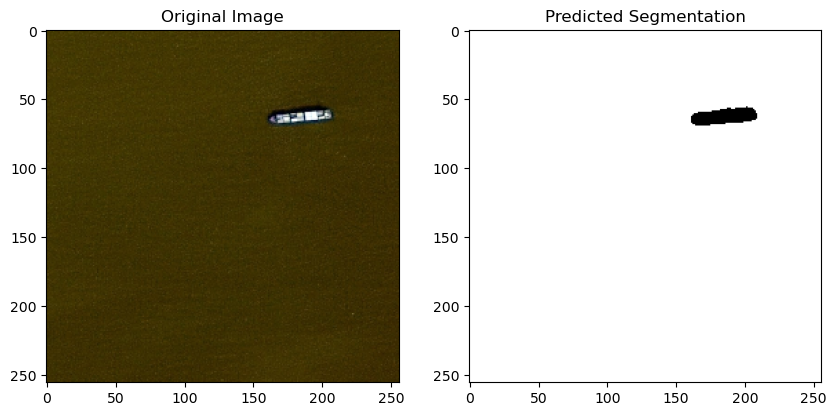

In [15]:
def preprocess_test_data(img_ids, img_dir):
    """This function preprocesses the image data"""
    X = np.zeros((len(img_ids), 256, 256, im_chan), dtype=np.uint8)

    for n, id_ in enumerate(img_ids):
        img_path = os.path.join(img_dir, id_)  # use os.path.join for safer path construction
        if not os.path.exists(img_path):
            print(f"Image path does not exist: {img_path}")
            continue

        # Load image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to read image: {img_path}")
            continue

        img = cv2.resize(img, (256, 256))  
        X[n] = img

    return X



img_dir = '/kaggle/input/airbus-ship-detection/test_v2/'

test_ids = ['00c3db267.jpg'] 

X_test = preprocess_test_data(test_ids, img_dir)

predicted_segmentation = model.predict(X_test)

predicted_segmentation = (predicted_segmentation > 0.9).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(X_test[0])
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_segmentation[0, ..., 0], cmap='gray')  
plt.title('Predicted Segmentation')
plt.show()


1/1 [==============================] - 0s 24ms/step


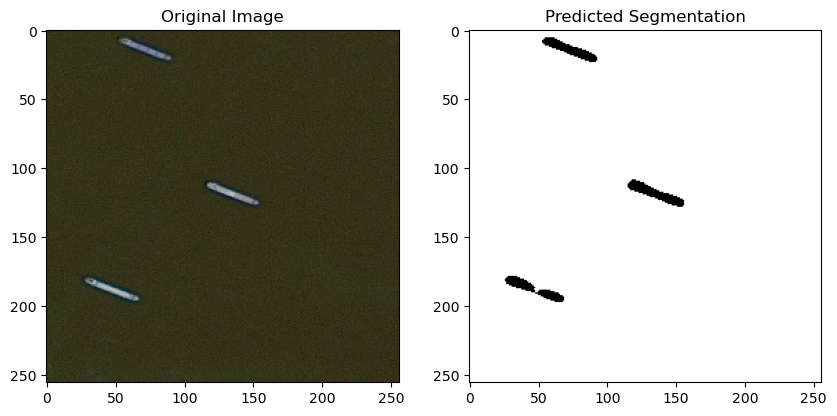

In [19]:
test_ids = ['00dc34840.jpg']  

X_test = preprocess_test_data(test_ids, img_dir)

predicted_segmentation = model.predict(X_test)

predicted_segmentation = (predicted_segmentation > 0.9).astype(np.float32)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(X_test[0])
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_segmentation[0, ..., 0], cmap='gray') 
plt.title('Predicted Segmentation')
plt.show()
